In [1]:
import pickle
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('../Data/allFLYs.pkl', 'rb') as pickle_file:
    allFLYs = pickle.load(pickle_file, encoding = 'latin1')

In [77]:
#gathering data for gaussians into a useable form

#pre-measuring length
length = 0
indices = [1] #indices for flights 342, (attenuation, polarization) = (30dB, N-S)
for i in indices:
    length += len(allFLYs[i]['x'])

#preallocating arrays for x, y, dish signal at each frequency, x,y angles for each dish, 
#and the polarization at each index

dish1signal, dish2signal, dish3signal, dish4signal = np.zeros((256, length)),np.zeros((256, length)),np.zeros((256, length)),np.zeros((256, length))
x_loc, y_loc = np.zeros(length), np.zeros(length)
dish1_thetax, dish2_thetax, dish3_thetax, dish4_thetax = np.zeros(length),np.zeros(length),np.zeros(length),np.zeros(length)
dish1_thetay, dish2_thetay, dish3_thetay, dish4_thetay = np.zeros(length),np.zeros(length),np.zeros(length),np.zeros(length)
polarization = np.empty(length, dtype = 'str')

countermin = 0
countermax = 0
for i in indices:
    countermax += len(allFLYs[i]['x'])
    
    x_loc[countermin:countermax] = allFLYs[i]['x']
    y_loc[countermin:countermax] = allFLYs[i]['y']
    
    for j in range(countermin,countermax):
        polarization[j] = allFLYs[i]['pol']
    
    dish1_thetax[countermin:countermax] = allFLYs[i]['thetaX'][0]
    dish2_thetax[countermin:countermax] = allFLYs[i]['thetaX'][1]
    dish3_thetax[countermin:countermax] = allFLYs[i]['thetaX'][2]
    dish4_thetax[countermin:countermax] = allFLYs[i]['thetaX'][3]
    
    dish1_thetay[countermin:countermax] = allFLYs[i]['thetaY'][0]
    dish2_thetay[countermin:countermax] = allFLYs[i]['thetaY'][1]
    dish3_thetay[countermin:countermax] = allFLYs[i]['thetaY'][2]
    dish4_thetay[countermin:countermax] = allFLYs[i]['thetaY'][3]
    
    autospectra = np.array(allFLYs[i]['autos'])
    
    for j in range(0, 256):
        dish1signal[j][countermin:countermax] = autospectra[0][:,j]
        dish2signal[j][countermin:countermax] = autospectra[1][:,j]
        dish3signal[j][countermin:countermax] = autospectra[2][:,j]
        dish4signal[j][countermin:countermax] = autospectra[3][:,j]
    
    countermin += len(allFLYs[i]['x'])

#creating some dummy variables that are used later for the x-y fits, even though those aren't useful
maxy = max(y_loc)
miny = min(y_loc)
maxx = max(x_loc)
minx = min(x_loc)
yrange = maxy - miny
xrange = maxx - minx

In [4]:
#general function to trim data

def data_trimmer(signal, x, y, xlim, ylim):
    
    truthtable = np.empty(len(x), dtype = bool)
    
    for i in range(len(x)):
        truthtable[i] = (np.abs(x[i])<=xlim) and (np.abs(y[i])<=ylim)
    
    xtrim = x[np.where(truthtable)]
    ytrim = y[np.where(truthtable)]
    sigtrim = signal[:,truthtable]
    
    return xtrim, ytrim, sigtrim

In [79]:
#creating trimmed thetaX-thetaY space data to avoid gaussian skewing

#defining limits by plotting and looking at plt.plot(thetaX, thetaY)
# overplotted w/ trimmed data, w/ some guess and check
#these limits make the data symmetrical about (thetaX, thetaY) = (0,0)
#for each dish
thetax_min1 = 0.26
thetay_min1 = 0.31

thetax_min2 = 0.29
thetay_min2 = 0.33

thetax_min3 = 0.265
thetay_min3 = 0.31

thetax_min4 = 0.245
thetay_min4 = 0.325
 
#calculating trimmed data
dish1_xtrim, dish1_ytrim, dish1_sigtrim = data_trimmer(dish1signal, dish1_thetax, dish1_thetay
                                                       , thetax_min1, thetay_min1)
dish2_xtrim, dish2_ytrim, dish2_sigtrim = data_trimmer(dish2signal, dish2_thetax, dish2_thetay
                                                       , thetax_min2, thetay_min2)
dish3_xtrim, dish3_ytrim, dish3_sigtrim = data_trimmer(dish3signal, dish3_thetax, dish3_thetay
                                                       , thetax_min3, thetay_min3)
dish4_xtrim, dish4_ytrim, dish4_sigtrim = data_trimmer(dish4signal, dish4_thetax, dish4_thetay
                                                       , thetax_min4, thetay_min4)

(-0.5, 0.5)

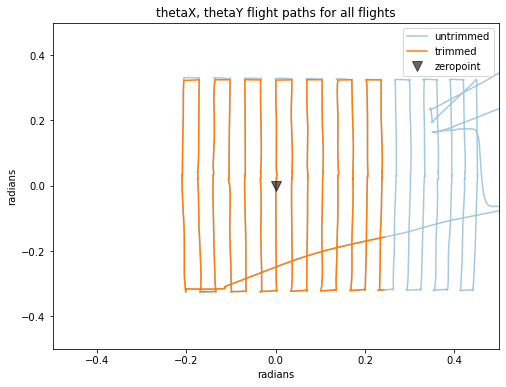

In [80]:
#visualizing the flight paths to properly trim data

fig = plt.figure(figsize=(8,6))
plt.plot(dish4_thetax, dish4_thetay, alpha = 0.4, label = 'untrimmed')
plt.plot(dish4_xtrim, dish4_ytrim, label = 'trimmed')
plt.plot(0,0, marker = 'v', markersize = 10, linewidth = 0, color = 'black', alpha = 0.6, label = 'zeropoint')
plt.title('thetaX, thetaY flight paths for all flights')
plt.xlabel('radians')
plt.legend()
plt.ylabel('radians')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)

In [81]:
#getting xmean, ymean initial guesses for better fits
#by getting the location of the maximum value at each frequency
#for each dish and for each coordinate system, (x, y), (thetaX, thetaY), (thetaX_trimmed, thetaY_trimmed)

#preallocation
dish1_thetax_mean, dish2_thetax_mean, dish3_thetax_mean, dish4_thetax_mean = np.zeros(256), np.zeros(256), np.zeros(256), np.zeros(256)
dish1_thetay_mean, dish2_thetay_mean, dish3_thetay_mean, dish4_thetay_mean = np.zeros(256), np.zeros(256), np.zeros(256), np.zeros(256)
dish1_xmean, dish2_xmean, dish3_xmean, dish4_xmean = np.zeros(256), np.zeros(256), np.zeros(256), np.zeros(256)
dish1_ymean, dish2_ymean, dish3_ymean, dish4_ymean = np.zeros(256), np.zeros(256), np.zeros(256), np.zeros(256)
dish1_xtrim_mean, dish2_xtrim_mean, dish3_xtrim_mean, dish4_xtrim_mean = np.zeros(256), np.zeros(256), np.zeros(256), np.zeros(256)
dish1_ytrim_mean, dish2_ytrim_mean, dish3_ytrim_mean, dish4_ytrim_mean = np.zeros(256), np.zeros(256), np.zeros(256), np.zeros(256)


#populating the arrays
for i in range(len(dish1signal)):
    dish1_thetax_mean[i] = dish1_thetax[np.where(dish1signal[i]==max(dish1signal[i]))]
    dish2_thetax_mean[i] = dish2_thetax[np.where(dish2signal[i]==max(dish2signal[i]))]
    dish3_thetax_mean[i] = dish3_thetax[np.where(dish3signal[i]==max(dish3signal[i]))]
    dish4_thetax_mean[i] = dish4_thetax[np.where(dish4signal[i]==max(dish4signal[i]))]
    
    dish1_thetay_mean[i] = dish1_thetay[np.where(dish1signal[i]==max(dish1signal[i]))]
    dish2_thetay_mean[i] = dish2_thetay[np.where(dish2signal[i]==max(dish2signal[i]))]
    dish3_thetay_mean[i] = dish3_thetay[np.where(dish3signal[i]==max(dish3signal[i]))]
    dish4_thetay_mean[i] = dish4_thetay[np.where(dish4signal[i]==max(dish4signal[i]))]
    
    dish1_xmean[i] = x_loc[np.where(dish1signal[i]==max(dish1signal[i]))]
    dish2_xmean[i] = x_loc[np.where(dish2signal[i]==max(dish2signal[i]))]
    dish3_xmean[i] = x_loc[np.where(dish3signal[i]==max(dish3signal[i]))]
    dish4_xmean[i] = x_loc[np.where(dish4signal[i]==max(dish4signal[i]))]
    
    dish1_ymean[i] = y_loc[np.where(dish1signal[i]==max(dish1signal[i]))]
    dish2_ymean[i] = y_loc[np.where(dish2signal[i]==max(dish2signal[i]))]
    dish3_ymean[i] = y_loc[np.where(dish3signal[i]==max(dish3signal[i]))]
    dish4_ymean[i] = y_loc[np.where(dish4signal[i]==max(dish4signal[i]))]
    
    dish1_xtrim_mean[i] = dish1_xtrim[np.where(dish1_sigtrim[i]==max(dish1_sigtrim[i]))]
    dish2_xtrim_mean[i] = dish2_xtrim[np.where(dish2_sigtrim[i]==max(dish2_sigtrim[i]))]
    dish3_xtrim_mean[i] = dish3_xtrim[np.where(dish3_sigtrim[i]==max(dish3_sigtrim[i]))]
    dish4_xtrim_mean[i] = dish4_xtrim[np.where(dish4_sigtrim[i]==max(dish4_sigtrim[i]))]
    
    dish1_ytrim_mean[i] = dish1_ytrim[np.where(dish1_sigtrim[i]==max(dish1_sigtrim[i]))]
    dish2_ytrim_mean[i] = dish2_ytrim[np.where(dish2_sigtrim[i]==max(dish2_sigtrim[i]))]
    dish3_ytrim_mean[i] = dish3_ytrim[np.where(dish3_sigtrim[i]==max(dish3_sigtrim[i]))]
    dish4_ytrim_mean[i] = dish4_ytrim[np.where(dish4_sigtrim[i]==max(dish4_sigtrim[i]))]

In [7]:
#defining gaussian fit
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    g = offset + amplitude * np.exp(-(((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g.ravel()

In [14]:
#defining a function to do the gaussian fits with all the bells and whistles
#change stuff here for different gaussfit parameters
#much easier than changing the parameters 4 times in multiple cells

def fit_calculator(sigdata, xdata, ydata, xstd, ystd, xmeans, ymeans):
    #preallocation
    gauss = np.empty(256, dtype = object)
    err = np.empty(256, dtype = object)
    #defining data tuples and boundaries
    datapoints = (xdata, ydata)
    lowerbounds = [-np.inf, min(xdata), min(ydata), -np.inf, -np.inf, -np.inf]
    upperbounds = [np.inf, max(xdata), max(ydata), np.abs(max(xdata)-min(xdata))
                   ,np.abs(max(ydata)-min(ydata)), np.inf]
    boundaries = (lowerbounds, upperbounds)
    
    #calculating gaussian fits
    for i in range(256):
        initialguess = (max(sigdata[i]), xmeans[i], ymeans[i], xstd, ystd, 0)
        m, cov = opt.curve_fit(twoD_Gaussian, datapoints, sigdata[i], p0 = initialguess, method = 'dogbox'
                              , jac = '2-point', maxfev = 100000, bounds = boundaries)
        gauss[i] = m
        err[i] = np.sqrt(np.diag(cov))
    
    return gauss, err

In [294]:
#testing gaussian fits and data aquisition using known graph (gaussfits in (x,y) space)
#see rightmost plot of slide 2 of 5_19 Plots.pptx
dish1gauss, dish1gauss_err = fit_calculator(dish1signal, x_loc, y_loc, 10, 10, dish1_xmean, dish1_ymean)
dish2gauss, dish2gauss_err = fit_calculator(dish2signal, x_loc, y_loc, 10, 10, dish2_xmean, dish2_ymean)
dish3gauss, dish3gauss_err = fit_calculator(dish3signal, x_loc, y_loc, 10, 10, dish3_xmean, dish3_ymean)
dish4gauss, dish4gauss_err = fit_calculator(dish4signal, x_loc, y_loc, 10, 10, dish4_xmean, dish4_ymean)

In [295]:
#creating plottable data arrays and errors for the x-y fits

#prealllocation
x1, x2, x3, x4 = np.zeros(256),np.zeros(256),np.zeros(256),np.zeros(256)
y1, y2, y3, y4 = np.zeros(256),np.zeros(256),np.zeros(256),np.zeros(256)
x1err, x2err, x3err, x4err = np.zeros(256),np.zeros(256),np.zeros(256),np.zeros(256)
y1err, y2err, y3err, y4err = np.zeros(256),np.zeros(256),np.zeros(256),np.zeros(256)
freq = np.zeros(256)

#every 16th data point for faster gaussfit calcs
#trimmed at the high and low end because no signal there, so fits are chaotic
for i in range(16,160,16):
    x1[i] = dish1gauss[i][1]-minx-xrange/2
    x2[i] = dish2gauss[i][1]-minx-xrange/2
    x3[i] = dish3gauss[i][1]-minx-xrange/2
    x4[i] = dish4gauss[i][1]-minx-xrange/2
    
    y1[i] = dish1gauss[i][2]-miny-yrange/2
    y2[i] = dish2gauss[i][2]-miny-yrange/2
    y3[i] = dish3gauss[i][2]-miny-yrange/2
    y4[i] = dish4gauss[i][2]-miny-yrange/2
    
    x1err = dish1gauss_err[i][1]
    x2err = dish2gauss_err[i][1]
    x3err = dish3gauss_err[i][1]
    x4err = dish4gauss_err[i][1]
    
    y1err = dish1gauss_err[i][2]
    y2err = dish2gauss_err[i][2]
    y3err = dish3gauss_err[i][2]
    y4err = dish4gauss_err[i][2]
    
    freq[i] = 1100 + (i * 2.1484375)

#plotting x-y space gaussians
fig = plt.figure(figsize = (8,6))

plt.errorbar(x1,y1, xerr=x1err, yerr = y1err, markersize = 3, marker = 'o', linewidth = 0, elinewidth = 1
             , color = 'gray', label = 'N Dish')
plt.errorbar(x2,y2, xerr=x2err, yerr = y2err, markersize = 3, marker = 'o', linewidth = 0, elinewidth = 1
             , color = 'blue', label = 'E Dish')
plt.errorbar(x3,y3, xerr=x3err, yerr = y3err, markersize = 3, marker = 'o', linewidth = 0, elinewidth = 1
             , color = 'green', label = 'S Dish')
plt.errorbar(x4,y4, xerr=x4err, yerr = y4err, markersize = 3, marker = 'o', linewidth = 0, elinewidth = 1
             , color = 'magenta', label = 'W Dish')
plt.scatter([-4, 3, 3.2, -10.5], [7.5, -3, 1.75, -1], s = 50, marker = 'v', color = 'black', label = 'Approx Ref Points')
plt.title('Dish center, Frequency Cross Section Test', fontsize = 16)
plt.xlabel('meters', fontsize = 12)
plt.ylabel('meters', fontsize = 12)
plt.legend()
#plt.savefig('NewGaussTest.png')
    

In [82]:
#calculating gaussian fits for untrimmed data

dish1gauss_theta_s, dish1gauss_theta_err_s = fit_calculator(dish1signal, dish1_thetax, dish1_thetay, 0.05, 0.05
                                                        , dish1_thetax_mean, dish1_thetay_mean)
dish2gauss_theta_s, dish2gauss_theta_err_s = fit_calculator(dish2signal, dish2_thetax, dish2_thetay, 0.05, 0.05
                                                        , dish2_thetax_mean, dish2_thetay_mean)
dish3gauss_theta_s, dish3gauss_theta_err_s = fit_calculator(dish3signal, dish3_thetax, dish3_thetay, 0.05, 0.05
                                                        , dish3_thetax_mean, dish3_thetay_mean)
dish4gauss_theta_s, dish4gauss_theta_err_s = fit_calculator(dish4signal, dish4_thetax, dish4_thetay, 0.05, 0.05
                                                        , dish4_thetax_mean, dish4_thetay_mean)

In [83]:
#calculating guassian fits for trimmed data

gausstrim1_s, gausstrim_err1_s = fit_calculator(dish1_sigtrim, dish1_xtrim, dish1_ytrim, 0.05, 0.05
                                           , dish1_xtrim_mean, dish1_ytrim_mean)
gausstrim2_s, gausstrim_err2_s = fit_calculator(dish2_sigtrim, dish2_xtrim, dish2_ytrim, 0.05, 0.05
                                           , dish2_xtrim_mean, dish2_ytrim_mean)
gausstrim3_s, gausstrim_err3_s = fit_calculator(dish3_sigtrim, dish3_xtrim, dish3_ytrim, 0.05, 0.05
                                           , dish3_xtrim_mean, dish3_ytrim_mean)
gausstrim4_s, gausstrim_err4_s = fit_calculator(dish4_sigtrim, dish4_xtrim, dish4_ytrim, 0.05, 0.05
                                           , dish4_xtrim_mean, dish4_ytrim_mean)

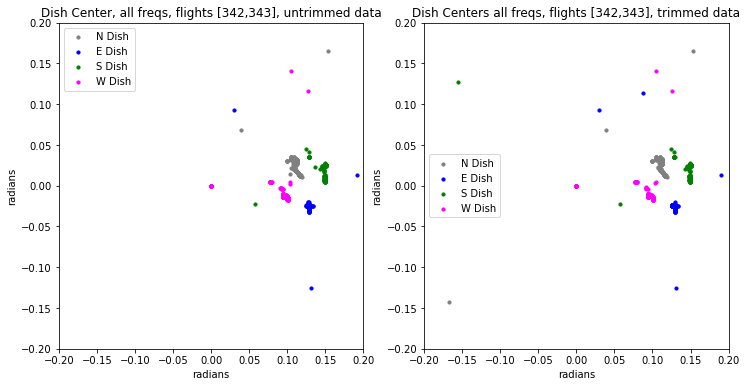

In [75]:
x10_trim, x20_trim, x30_trim, x40_trim = np.zeros(256),np.zeros(256),np.zeros(256),np.zeros(256)
y10_trim, y20_trim, y30_trim, y40_trim = np.zeros(256),np.zeros(256),np.zeros(256),np.zeros(256)
x10, x20, x30, x40 = np.zeros(256),np.zeros(256),np.zeros(256),np.zeros(256)
y10, y20, y30, y40 = np.zeros(256),np.zeros(256),np.zeros(256),np.zeros(256)

for i in range(23,200):
    x10_trim[i] = gausstrim1[i][1]
    x20_trim[i] = gausstrim2[i][1]
    x30_trim[i] = gausstrim3[i][1]
    x40_trim[i] = gausstrim4[i][1]
    
    y10_trim[i] = gausstrim1[i][2]
    y20_trim[i] = gausstrim2[i][2]
    y30_trim[i] = gausstrim3[i][2]
    y40_trim[i] = gausstrim4[i][2]
    
    x10[i] = dish1gauss_theta[i][1]
    x20[i] = dish2gauss_theta[i][1]
    x30[i] = dish3gauss_theta[i][1]
    x40[i] = dish4gauss_theta[i][1]
    
    y10[i] = dish1gauss_theta[i][2]
    y20[i] = dish2gauss_theta[i][2]
    y30[i] = dish3gauss_theta[i][2]
    y40[i] = dish4gauss_theta[i][2]
    
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,6))
ax1, ax2 = axs

ax1.scatter(x10,y10, s = 10, color = 'gray', label = 'N Dish')
ax1.scatter(x20,y20, s = 10, color = 'blue', label = 'E Dish')
ax1.scatter(x30,y30, s = 10, color = 'green', label = 'S Dish')
ax1.scatter(x40,y40, s = 10, color = 'magenta', label = 'W Dish')
ax1.set_title('Dish Center, all freqs, flights [342,343], untrimmed data')
ax1.set_ylabel('radians')
ax1.set_xlabel('radians')
ax1.legend()
ax1.set_xlim(-0.2,0.2)
ax1.set_ylim(-0.2,0.2)

ax2.scatter(x10_trim,y10_trim, s = 10, color = 'gray', label = 'N Dish')
ax2.scatter(x20_trim,y20_trim, s = 10, color = 'blue', label = 'E Dish')
ax2.scatter(x30_trim,y30_trim, s = 10, color = 'green', label = 'S Dish')
ax2.scatter(x40_trim,y40_trim, s = 10, color = 'magenta', label = 'W Dish')
ax2.set_title('Dish Centers all freqs, flights [342,343], trimmed data')
ax2.set_ylabel('radians')
ax2.set_xlabel('radians')
ax2.set_xlim(-0.2,0.2)
ax2.set_ylim(-0.2,0.2)
ax2.legend()

(0.0, 0.5)

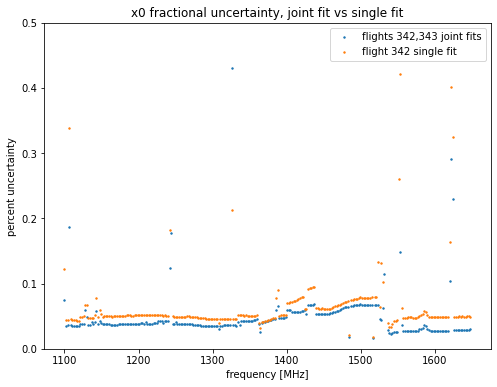

In [92]:
x_j_frac1, x_j_frac2, x_j_frac3, x_j_frac4  = np.zeros(256), np.zeros(256), np.zeros(256), np.zeros(256)
x_s_frac1, x_s_frac2, x_s_frac3, x_s_frac4  = np.zeros(256), np.zeros(256), np.zeros(256), np.zeros(256)
freq = np.zeros(256)
for i in range(256):
    freq[i] = 1100 + i*2.1484375
    
    x_j_frac1[i] = 100 * dish1gauss_theta_err[i][1]/dish1gauss_theta[i][1]
    x_j_frac2[i] = dish2gauss_theta_err[i][1]/dish2gauss_theta[i][1]
    x_j_frac3[i] = dish3gauss_theta_err[i][1]/dish3gauss_theta[i][1]
    x_j_frac4[i] = dish4gauss_theta_err[i][1]/dish4gauss_theta[i][1]
    
    x_s_frac1[i] = 100 * dish1gauss_theta_err_s[i][1]/dish1gauss_theta_s[i][1]
    x_s_frac2[i] = dish2gauss_theta_err_s[i][1]/dish2gauss_theta_s[i][1]
    x_s_frac3[i] = dish3gauss_theta_err_s[i][1]/dish3gauss_theta_s[i][1]
    x_s_frac4[i] = dish4gauss_theta_err_s[i][1]/dish4gauss_theta_s[i][1]

fig = plt.figure(figsize=(8,6))
plt.scatter(freq, x_j_frac1,s = 2, label = 'flights 342,343 joint fits')
plt.scatter(freq, x_s_frac1, s = 2, label = 'flight 342 single fit')
plt.xlabel('frequency [MHz]')
plt.title('x0 fractional uncertainty, joint fit vs single fit')
plt.legend()
plt.ylabel('percent uncertainty')
plt.ylim(0, 0.5)

NameError: name 'freq' is not defined